In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from src.get_data import *
from src.models import *
from src.utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
learning_iters = 200
learning_lr = 1e-3
inference_iters = 200
inference_lr = 0.01
batch_size = 20
noise_var = 0.05
divisor = 2
image_size = 32
sample_size = 20 
sample_size_test = 20
lamb = 0
repeat = 1

for seed in range(repeat):
    (X, y), (X_test, y_test) = get_cifar10('../data', 
                                        sample_size=sample_size, 
                                        sample_size_test=sample_size_test,
                                        batch_size=batch_size, 
                                        seed=seed, 
                                        device=device,
                                        classes=None) # small number of classes
    size = X.shape
    flattened_size = size[-1]*size[-2]*size[-3]
    X_c, update_mask = add_gaussian_noise(X, noise_var, device)
    X = X.reshape(-1, size[-1]*size[-2]*size[-3])
    _, update_mask_test = add_gaussian_noise(X_test, noise_var, device)
    X_test = X_test.reshape(-1, size[-1]*size[-2]*size[-3])

    print(flattened_size)

    nodes = [256, 256, flattened_size]
    pcn_h = HierarchicalPCN(nodes, 'Tanh', inference_lr, lamb).to(device)
    init_mem = pcn_h.memory.clone().detach()
    optimizer = torch.optim.Adam(pcn_h.parameters(), lr=learning_lr)

    train_mses = []
    for i in range(learning_iters):
        if i % 10 == 0:
            print('Epoch', i)
        for batch_idx in range(0, sample_size, batch_size):
            data = X[batch_idx:batch_idx+batch_size]
            optimizer.zero_grad()
            pcn_h.train_pc_generative(data, inference_iters, update_mask)
            optimizer.step()
        train_mses.append(torch.mean(pcn_h.errs[-1]**2))

Files already downloaded and verified
Files already downloaded and verified
3072
Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190


cosine sim: 0.24155197


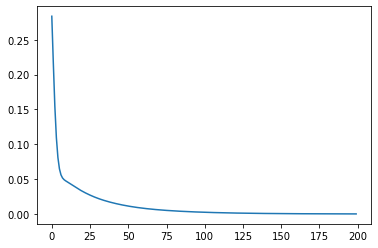

In [3]:
latent = pcn_h.val_nodes[0].cpu().detach().numpy()
cos_mat = cosine_similarity(latent)
print("cosine sim:", np.mean(np.abs(cos_mat)))

plt.figure()
plt.plot([mse.cpu().detach().numpy() for mse in train_mses])
plt.show()